# Lecture 06, Hierarchical Clustering with Ward, SAS workflow, interpretation

This notebook is a teaching handout. It follows Gunning Fog level about 8 by using short sentences and clear words. It mirrors the lecture transcript and **Lecture06** slides. It shows the workflow in SAS, then how to profile clusters. It adds small Python demos for intuition.

## 1) Big picture, why clustering

Clustering groups similar cases. We use it to segment customers. Each group can get a different offer, message, or layout. Hierarchical clustering builds a tree, called a dendrogram. We then cut the tree to get **K** clusters.

**Ward’s method** works well for survey and opinion data. It keeps groups tight inside, and far apart between groups. In plain words, it **minimizes the within group variance** at each merge. That also **maximizes separation** across groups.

## 2) Ward’s method in one line

At every merge, join the two clusters that cause the **smallest increase** in total within cluster variance, also called error sum of squares. This favors round and compact clusters which are easy to explain.

## 3) SAS workflow, from data to clusters

Below is the same code used in class. It reads table `c.unico_1`, runs hierarchical clustering, saves the tree, cuts it at **K = 3**, and merges the cluster labels back to the base table.


In [ ]:
```sas
/* Libraries */
libname c 'C:\Camillo_clabe';

/* 1) Try a different linkage to see behavior */
proc cluster data=c.unico_1 method=single outtree=c.tree;
  var d10_:;
  id id;
run;
proc tree data=c.tree;
  id id;
run;

/* 2) Ward, our main choice */
proc cluster data=c.unico_1 method=ward outtree=c.tree_1;
  var d10_:;   /* all variables whose names start with d10_ */
  id id;       /* record id follows the unit through the tree */
run;
proc tree data=c.tree_1;
  id id;
run;

/* 3) Cut the tree to get K = 3 clusters */
proc tree data=c.tree_1 noprint out=c.cluster nclusters=3;
  id id;
run;

/* 4) Sort by the join key before a merge */
proc sort data=c.cluster; by id; run;

/* 5) Merge cluster labels back into the original data */
data c.unico_2;
  merge c.unico_1 c.cluster;  /* creates a new column named CLUSTER */
  by id;                      /* key must be sorted in both inputs */
run;

/* 6) Size of each cluster */
proc freq data=c.unico_2;
  table cluster;
run;

/* 7) Cross tab with a descriptor, example sex, with expected counts */
proc freq data=c.unico_2;
  table cluster*sex / expected;
run;
```

### Common pitfalls
- **Sort before merge**. Use `proc sort by id`.
- **Close tables before reuse**. You cannot sort a dataset that is still open in a viewer.
- **Do not overwrite**. Save new outputs with new names, for example `unico_2`.
- **Library path must exist**. If `libname` points to a non existing path, SAS will not assign it.
- **Missing values**. Procedures ignore rows with missing values in required fields. Your cluster counts may drop.

## 4) Reading the dendrogram and picking K

- The vertical axis is **fusion distance**. Under Ward, it is the increase in within variance at a merge.
- A **long jump** signals two different branches got fused. Cut **right before** such jumps.
- Use two levels of detail: a **main segmentation** for strategy, and **subsegments** inside each branch for tactics.

## 5) What the new variable `cluster` means

`cluster` is a categorical field derived from many inputs, here `d10_1` to `d10_8`. It is an **enrichment** of the customer master. With this one field, teams can filter, run A/B tests per segment, and tailor offers. Keep the join key `id` with it.

## 6) Cluster sizing, small Python demo

We will make a toy table of sizes, then plot it. In class, your `PROC FREQ` output gave similar numbers. The code below only builds intuition.

In [3]:
import pandas as pd

sizes = pd.Series({1: 306, 2: 318, 3: 160}, name='Frequency')
perc = sizes / sizes.sum() * 100
df_sizes = pd.DataFrame({'Frequency': sizes, 'Percent': perc.round(1)})

# Just display the dataframe directly (no need for caas_jupyter_tools)
df_sizes

,Frequency,Percent
1,306,39.0
2,318,40.6
3,160,20.4


### Bar chart of toy cluster sizes
One chart per figure, default matplotlib style, no custom colors.

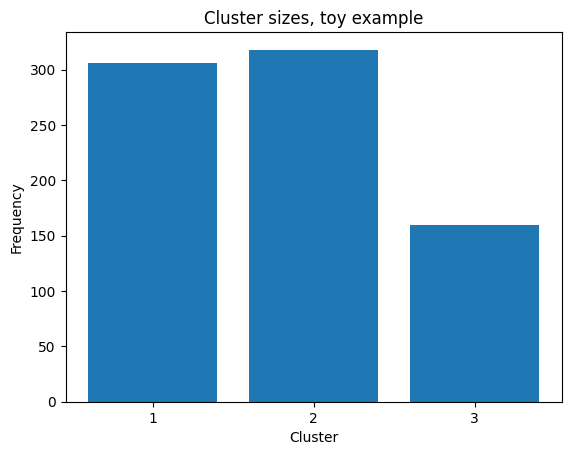

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(df_sizes.index.astype(str), df_sizes['Frequency'])
plt.title('Cluster sizes, toy example')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

## 7) Cross tabs and expected counts, logic of independence

We compare within cluster percents to overall percents. If they match, the variables are independent. If not, there is a relation. The expected count under independence for cell `(i, j)` is

$$E_{ij} = \frac{(\text{row total}_i) (\text{column total}_j)}{\text{grand total}}.$$

The code below shows the computation for a toy 2 by 3 table. In SAS, `PROC FREQ ... / expected` prints the same expected counts.

In [5]:
import numpy as np
import pandas as pd

# toy cross tab: rows are clusters 1..3, columns are sex: F, M
obs = pd.DataFrame({
    'F':[140, 150, 86],   # sample numbers, adjust in class
    'M':[166, 168, 74]
}, index=[1,2,3])
obs['RowTotal'] = obs.sum(axis=1)
col_totals = obs[['F','M']].sum(axis=0)
grand = col_totals.sum()

# expected under independence
expected = pd.DataFrame(index=obs.index, columns=['F','M'], dtype=float)
for r in obs.index:
    for c in ['F','M']:
        expected.loc[r, c] = obs.loc[r, 'RowTotal'] * col_totals[c] / grand

chi2 = (((obs[['F','M']] - expected)**2) / expected).to_numpy().sum()
df = (len(obs.index)-1) * (len(['F','M'])-1)

print('Observed counts:\n', obs[['F','M']])
print('\nExpected counts (independence):\n', expected.round(2))
print(f"\nChi-square statistic (no p-value computed): {chi2:.3f}, df={df}")

Observed counts:
      F    M
1  140  166
2  150  168
3   86   74

Expected counts (independence):
         F       M
1  146.76  159.24
2  152.51  165.49
3   76.73   83.27

Chi-square statistic (no p-value computed): 2.827, df=2


## 8) Analyst checklist

- Variables are ready, scaled if needed, and missing patterns are known.
- `proc cluster method=ward` with `outtree=` saved.
- Inspect dendrogram, mark jumps, pick **K**.
- `proc tree ... nclusters=K out=cluster`.
- `proc sort` by `id`, then `merge` back to base table.
- `proc freq` on `cluster`, and `cluster * descriptors` with `/ expected`.
- Write a one page segment profile with size, key traits, and quick actions.

## 9) Notes from the lab setup

- Copy the course folder to your own virtual disk before class. You can read the teacher folder, but you cannot write there.
- Launch **SAS 9.4 English** in the lab image.
- Drag the `.sas` file into the editor to open it.
- Use a readable font size, for example 16.

---
### Appendix, talking points for stakeholders

- **Cluster 1** is slightly more male than average, it may need different creative.
- **Cluster 2** follows the base mix on sex, no special targeting by gender.
- **Cluster 3** is smaller and stands apart in the tree, it may need a custom plan.